# Regression model to predict Asthma prevalence from Air quality data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Two datasets are merged in this project "Air Quality" and "Asthma prevalence"

The 1st dataset is "1980-2021 Yearly Air Quality Index from the EPA"
https://www.kaggle.com/threnjen/40-years-of-air-quality-index-from-the-epa-yearly

Note: I use data only for one year 2016, because my second dataset has data only for - 2017
Why not 2017 and 2017? Because 2016 - 2017 gives better RMSE. 
It means If you move to the place with bad air quality, you will get your Asthma only next year :)

In [2]:
#1st dataset for Air-quality by Counties of USA
dataAir = 'aqi_yearly_1980_to_2021.csv'
usecols = ['State', 'County', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days', 
           'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days',
           'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days SO2',
           'Days PM2.5', 'Days PM10', 'Latitude', 'Longitude']
dfAir = pd.read_csv(dataAir, usecols=usecols)

dfAir = dfAir[(dfAir['Year']==2016)]
del dfAir['Year']

print(len(dfAir))

1003


In [3]:
#EDA: Remove spaces from column names and data, changing cases
dfAir.columns = dfAir.columns.str.lower().str.replace(' ', '_')
strings = list(dfAir.dtypes[dfAir.dtypes == 'object'].index)
for col in strings:
    dfAir[col] = dfAir[col].str.lower().str.strip().str.replace(' ', '_')

The 2nd dataset is "PLACES: County Data (GIS Friendly Format), 2020 release"
https://chronicdata.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2020-releas/i46a-9kgh

In [4]:
#2nd dataset for Asthma prevalence by Counties of USA
usecols = ['StateDesc', 'CountyName', 'TotalPopulation', 'CASTHMA_AdjPrev']
dataAsthma = 'PLACES_County_Data.csv'
dfAsthma = pd.read_csv(dataAsthma, usecols=usecols)
print('Number of rows for dataset', len(dfAsthma))

Number of rows for dataset 3142


In [5]:
#EDA: Remove spaces from column names and data
#Rename coumns to keep it consistent for both datasets 
dfAsthma.columns = dfAsthma.columns.str.lower().str.replace(' ', '_')
strings = list(dfAsthma.dtypes[dfAsthma.dtypes == 'object'].index)
for col in strings:
    dfAsthma[col] = dfAsthma[col].str.lower().str.replace(' ', '_')
dfAsthma = dfAsthma.rename(columns={"countyname": "county", "statedesc": "state"})

In [6]:
#EDA: Merge both datasets by two columns: 'state' and 'county'
df = pd.merge(dfAir, dfAsthma, left_on=['state','county'], right_on = ['state','county'], how='inner')

In [7]:
#EDA: Exploring our target column - casthma_adjprev.
#This is Asthma prevalence for some area ajusted by age (in %) 
df.casthma_adjprev.describe()

count    972.000000
mean       9.831481
std        0.940472
min        7.100000
25%        9.200000
50%        9.800000
75%       10.400000
max       15.400000
Name: casthma_adjprev, dtype: float64

In [8]:
#EDA: Length of data and null values for merged dataset

In [9]:
print('Length of data of merged  dataset:', len(df))
print('Null values for merged dataset:', df.isnull().sum())

Length of data of merged  dataset 972
Null values for merged dataset state                                  0
county                                 0
days_with_aqi                          0
good_days                              0
moderate_days                          0
unhealthy_for_sensitive_groups_days    0
unhealthy_days                         0
very_unhealthy_days                    0
hazardous_days                         0
median_aqi                             0
days_co                                0
days_no2                               0
days_ozone                             0
days_so2                               0
days_pm2.5                             0
days_pm10                              0
latitude                               0
longitude                              0
totalpopulation                        0
casthma_adjprev                        0
dtype: int64


In [10]:
#EDA: Target column graphs ('as is' and with log1p)

<AxesSubplot:xlabel='casthma_adjprev', ylabel='Density'>

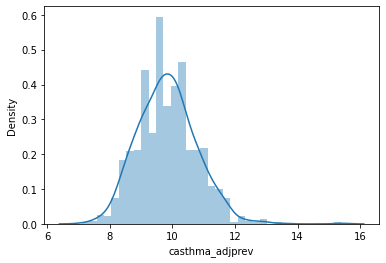

In [11]:
sns.distplot(df.casthma_adjprev)

<AxesSubplot:xlabel='casthma_adjprev', ylabel='Density'>

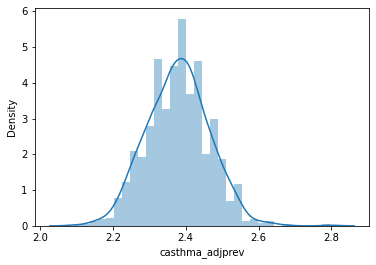

In [12]:
sns.distplot(np.log1p(df.casthma_adjprev))

In [13]:
#Split data to training, validation and test set

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.casthma_adjprev.values)
y_val = np.log1p(df_val.casthma_adjprev.values)
y_test = np.log1p(df_test.casthma_adjprev.values)

del df_train['casthma_adjprev']
del df_val['casthma_adjprev']
del df_test['casthma_adjprev']

print(len(df_train))
print(len(df_val))
print(len(df_test))

582
195
195


In [15]:
#EDA:Heatmap showing correlations between numerical data

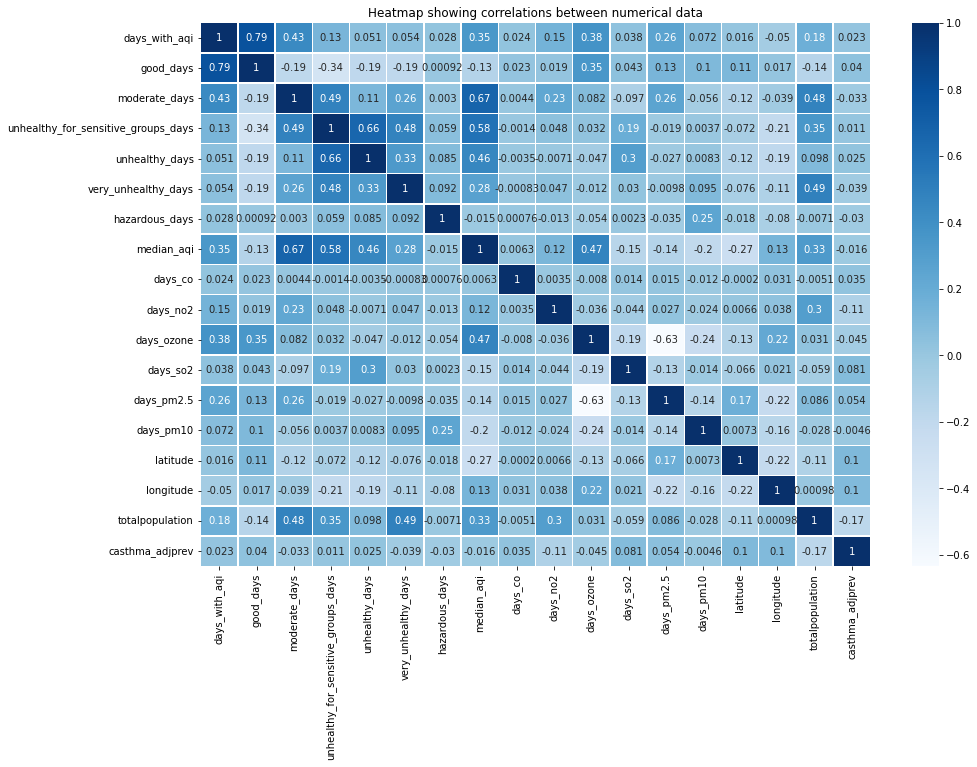

In [16]:
data_numeric = df_full_train.copy()
data_numeric = df_full_train.drop(["state","county"], axis=1)
plt.figure(figsize=(15,10))  
sns.heatmap(data_numeric.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [17]:
#EDA: The same correlations between numerical data but in text format:

In [18]:
data_numeric.corr().unstack().sort_values(ascending = False).head(45)

casthma_adjprev                      casthma_adjprev                        1.000000
days_co                              days_co                                1.000000
latitude                             latitude                               1.000000
days_pm10                            days_pm10                              1.000000
days_pm2.5                           days_pm2.5                             1.000000
days_so2                             days_so2                               1.000000
days_ozone                           days_ozone                             1.000000
days_no2                             days_no2                               1.000000
median_aqi                           median_aqi                             1.000000
totalpopulation                      totalpopulation                        1.000000
hazardous_days                       hazardous_days                         1.000000
very_unhealthy_days                  very_unhealthy_days         

In [19]:
#EDA: Correlations between categorical data and target variable

In [20]:
#EDA: To compare correlations let's transform numerical 'casthma_adjprev' data to categorical
pd.cut(np.log1p(df_full_train.casthma_adjprev), bins=10).value_counts()

(2.329, 2.396]    225
(2.396, 2.463]    209
(2.262, 2.329]    131
(2.463, 2.53]      98
(2.195, 2.262]     72
(2.53, 2.597]      26
(2.128, 2.195]     11
(2.597, 2.663]      3
(2.73, 2.797]       1
(2.663, 2.73]       1
Name: casthma_adjprev, dtype: int64

In [21]:
#EDA: Results for categorical data correlations:
qcasthma = pd.qcut(df_full_train.casthma_adjprev, q=10)
from sklearn.metrics import normalized_mutual_info_score
print('Correlation between County and asthma:', normalized_mutual_info_score(df_full_train.county, qcasthma))
print('Correlation between  State and asthma:', normalized_mutual_info_score(df_full_train.state, qcasthma))
print('Correlation between County and  State:', normalized_mutual_info_score(df_full_train.county, df_full_train.state))

Correlation between County and asthma: 0.4575732267425729
Correlation between  State and asthma: 0.22507445192860256
Correlation between County and  State: 0.6679278581994617


In [22]:
#Let's create dictionaries for training and validation data:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [23]:
#Fit and transform model
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# 1st model is a linear "Lasso" model with alpha parameter tuning

In [24]:
from sklearn.linear_model import Lasso
for a in [0, 0.001, 0.01, 0.1, 2, 3, 4]:
    lr = Lasso(alpha=a)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print('a: ', a, 'score: ', score)

a:  0 score:  0.13687351242950788
a:  0.001 score:  0.06972316416639601
a:  0.01 score:  0.08146370866097395
a:  0.1 score:  0.08189382450392586
a:  2 score:  0.08218608659756435
a:  3 score:  0.08218624576615575
a:  4 score:  0.08218640494565965


The best RMSE for linear Lasso model is *0.069* with alpha=0.001

I also compared RMSE for air quality data for previos years (2017, 2016, 2015).
2016 is the best one. It matches with asthma prevalence data for 2017.

2017 a:  0.001 score:  0.0742091332330527
2016 a:  0.001 score:  0.06972316416639601
2015 a:  0.001 score:  0.07581399693639637

# 2nd model is a linear "Ridge" model with alpha parameter tuning

In [25]:
from sklearn.linear_model import Ridge
for a in [0.001, 0.01, 0.1, 2, 3, 3.5, 4, 10]:
    model = Ridge(alpha=a,random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print('a: ', a, 'score: ', score)

a:  0.001 score:  0.19670207397435527
a:  0.01 score:  0.09387713002062435
a:  0.1 score:  0.07623854967657456
a:  2 score:  0.06826597834762965
a:  3 score:  0.06798535348388787
a:  3.5 score:  0.068034387417815
a:  4 score:  0.06816106727931154
a:  10 score:  0.07156872050262131


The best RMSE for linear Ridge model is *0.067* with alpha=3

I also compared RMSE for air quality data for previos years (2017, 2016, 2015).
2016 is the best one. It matches with asthma prevalence data for 2017.

2017 a: 3 score:  0.06646176277140042
2016 a: 3 score:  0.06798535348388787
2015 a: 3 score:  0.06556374731153568

# 3rd model is a tree "DecisionTreeRegressor" with max_depth param tuning

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

for a in [3, 5, 7, 10, 15, 20, 30]:
    dt = DecisionTreeRegressor(max_depth=a)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    print('max_depth: ', a, 'score: ', score)

max_depth:  3 score:  0.07617192042785516
max_depth:  5 score:  0.07357486901343005
max_depth:  7 score:  0.06912687447077363
max_depth:  10 score:  0.06867669222015328
max_depth:  15 score:  0.06920544631222406
max_depth:  20 score:  0.08266730973425063
max_depth:  30 score:  0.07686852408445209


The best RMSE for tree DecisionTreeRegressor model is *0.068* with max_depth=10

I also compared RMSE for air quality data for previos years (2017, 2016, 2015) 
2016 is the best one. 
It matches with asthma prevalence data for 2017.

2017 - 0.07674271714140564
2016 - 0.06827253126945587
2015 - 0.07792719460444107

In [27]:
# Let's test our model with data from test dataset (just one example).
test_dicts = df_test.iloc[6].to_dict()
X_test = dv.transform(test_dicts)
y_pred = dt.predict(X_test)
print(np.expm1(y_pred))
print(np.expm1(y_test[6]))

[9.9]
10.1


In [28]:
# Our tree model lokks like:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- latitude <= 30.63
|   |--- totalpopulation <= 350077.50
|   |   |--- latitude <= 29.62
|   |   |   |--- unhealthy_for_sensitive_groups_days <= 0.50
|   |   |   |   |--- days_with_aqi <= 358.50
|   |   |   |   |   |--- days_no2 <= 29.00
|   |   |   |   |   |   |--- value: [2.28]
|   |   |   |   |   |--- days_no2 >  29.00
|   |   |   |   |   |   |--- value: [2.33]
|   |   |   |   |--- days_with_aqi >  358.50
|   |   |   |   |   |--- good_days <= 324.00
|   |   |   |   |   |   |--- median_aqi <= 38.00
|   |   |   |   |   |   |   |--- value: [2.26]
|   |   |   |   |   |   |--- median_aqi >  38.00
|   |   |   |   |   |   |   |--- value: [2.24]
|   |   |   |   |   |--- good_days >  324.00
|   |   |   |   |   |   |--- value: [2.22]
|   |   |   |--- unhealthy_for_sensitive_groups_days >  0.50
|   |   |   |   |--- county=alachua <= 0.50
|   |   |   |   |   |--- median_aqi <= 37.50
|   |   |   |   |   |   |--- state=florida <= 0.50
|   |   |   |   |   |   |   |--- value: [2.35]
|   |   |   

# 4th model is an ensemble "RandomForestRegressor" with n_estimators and max_depth parameters tuning

In [29]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
scores = []

for d in tqdm([10, 15, 20, 45]):
    rfr = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 221, 10)):
        rfr.n_estimators = n
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

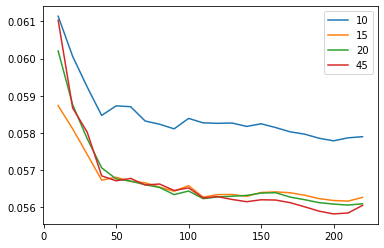

In [30]:
for d in [10, 15, 20, 45]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)
plt.legend()

The best RMSE for an ensemble "RandomForestRegressor" model is *0.055* with max_depth=45 and n_estimators=200
You can see this on the graph above in red.

I also compared RMSE for air quality data for previos years (2017, 2016, 2015)
2016 is the best one. 
It matches with asthma prevalence data for 2017.

2017 0.06234757551853855
2016 0.0558254842536313
2015 0.05917650023817026

In [31]:
# Let's test our model with data from test dataset (just one example).
test_dicts = df_test.iloc[6].to_dict()
X_test = dv.transform(test_dicts)
y_pred = rfr.predict(X_test)
print(np.expm1(y_pred))
print(np.expm1(y_test[6]))

[9.90240816]
10.1


# The best model is an ensemble "RandomForestRegressor" with max_depth=45 and n_estimators=200
It gives *0.055* RMSE. 
Other models: DecisionTree: 0.068, Ringe: 0.067, Lasso: 0.069

In [32]:
#EDA: Feature importance analysis.

In [33]:
fr = RandomForestRegressor(n_estimators=200, max_depth=45, 
                           random_state=1, n_jobs=-1)
fr.fit(X_train, y_train)

df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = fr.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(12)

,feature,importance
475,latitude,0.188769
476,longitude,0.166235
530,totalpopulation,0.092717
473,good_days,0.044275
516,state=oregon,0.043708
470,days_pm2.5,0.035487
468,days_ozone,0.030397
467,days_no2,0.029344
478,moderate_days,0.027579
502,state=minnesota,0.026049


In [34]:
# Let's save our best model and dictionary for "RandomForestRegressor" 
import pickle
model_file = 'model1.bin'
dv_file = 'dv1.bin'

with open(model_file, 'wb') as f_out: 
    pickle.dump((fr), f_out)

with open(dv_file, 'wb') as f_out: 
    pickle.dump((dv), f_out)
    
fr

RandomForestRegressor(max_depth=45, n_estimators=200, n_jobs=-1, random_state=1)

In [35]:
#Test example 1
place = {'state': 'nevada',
 'county': 'baldwin',
 'days_with_aqi': 366,
 'good_days': 105,
 'moderate_days': 115,
 'unhealthy_for_sensitive_groups_days': 35,
 'unhealthy_days': 1,
 'very_unhealthy_days': 1,
 'hazardous_days': 1,
 'median_aqi': 58,
 'days_co': 50,
 'days_no2': 57,
 'days_ozone': 219,
 'days_so2': 0,
 'days_pm2.5': 114,
 'days_pm10': 6,
 'latitude': 16.569333,
 'longitude': -105.676651,
 'totalpopulation': 2231647}

X = dv.transform([place])
y_pred = rfr.predict(X)[0]
print("Prevalece of Asthma in % for this place. (min: 7.1, mean: 9.83, max: 15.4)")
print('output:', np.expm1(y_pred))

Prevalece of Asthma in % for this place. (min: 7.1, mean: 9.83, max: 15.4)
output: 8.63538890297751


# Test example with request to Flask service 
# You have to launch it before sending request - take a look at readme

In [36]:
import requests
url = 'http://localhost:9696/predict'
place = {'state': 'nevada',
 'county': 'clark',
 'days_with_aqi': 366,
 'good_days': 125,
 'moderate_days': 215,
 'unhealthy_for_sensitive_groups_days': 25,
 'unhealthy_days': 0,
 'very_unhealthy_days': 1,
 'hazardous_days': 0,
 'median_aqi': 58,
 'days_co': 0,
 'days_no2': 27,
 'days_ozone': 1,
 'days_so2': 0,
 'days_pm2.5': 114,
 'days_pm10': 6,
 'latitude': 36.569333,
 'longitude': -115.676651,
 'totalpopulation': 2231647}

response = requests.post(url, json=place).json()
print("Prevalece of Asthma in % for this place. (min: 7.1, mean: 9.83, max: 15.4)")
print(response)

Prevalece of Asthma in % for this place. (min: 7.1, mean: 9.83, max: 15.4)
{'asthma_prevalence': 9.122216920169867}
